In [1]:
import numpy as np
import pandas as pd

import json
import itertools
import random
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from matplotlib import pyplot as plt
import seaborn as sns

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import util

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Pull Spotify Data

In [2]:
CLIENT_ID="810e2eec841546269c49f338f1be189a"
CLIENT_SECRET="764290d0ab0f4f4484b0d4c7b701bdee"

token = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

cache_token = token.get_access_token()
sp = spotipy.Spotify(cache_token)

In [3]:
# Pull data
TRACK_DATA_PATH = "data/tracks_5kalbums.json"
with open(TRACK_DATA_PATH,'r') as ff:
    songs = json.load(ff)
    
# Remove duplicates
songs.sort()
songs = list(s for s,_ in itertools.groupby(songs))
print("Loaded {} songs from {}".format(len(songs), TRACK_DATA_PATH))
print("First ten songs: {}".format(songs[:10]))

Loaded 11841 songs from data/tracks_5kalbums.json
First ten songs: [['000InFFKfurNhrCj7yfMdM', 'Park Bench People', 1], ['003eoIwxETJujVWmNFMoZy', 'Growing Pains', 70], ['00518PumkDdn560MsfLofT', 'The Fuss', 46], ['005FoVr63RI753jsNjfLax', 'Black Panther', 31], ['009Mof2o4aS1P2l3FbaEpa', 'Quetzal', 30], ['009TjPzPuetzFiJNnBEVrV', 'Used and Abused', 51], ['00I0pcNkN3IOX3fsYbaB4N', 'Infatuation', 68], ['00KiXBZT9vf1XhcqkFrzug', 'Downward', 46], ['00KjOnN3U40e3lXFUOue7h', '10AM/Save The World (feat. Gucci Mane)', 69], ['00Le8soPbjYT0TxmXflHmi', 'A God Who Sees (Me & Lucy)', 39]]


## Data Exploration

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


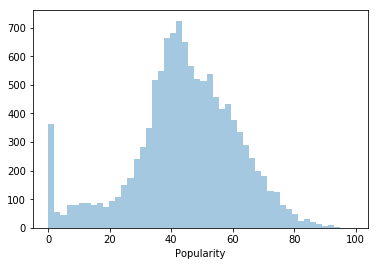

In [4]:
# Plot popularity distribution
sns.distplot([s[2] for s in songs], rug=False, kde=False, axlabel="Popularity")

In [5]:
# Extract top 5 most popular songs
sorted(songs, key=lambda song: song[2])[-10:]

[['0s3nnoMeVWz3989MkNQiRf', 'Lucid Dreams', 93],
 ['14JzyD6FlBD5z0wV5P07YI', "when the party's over", 93],
 ['1xzBco0xcoJEDXktl7Jxrr', 'Mo Bamba', 93],
 ['3EPXxR3ImUwfayaurPi3cm', 'Be Alright', 93],
 ['0d2iYfpKoM0QCKvcLCkBao', 'Eastside (with Halsey & Khalid)', 94],
 ['1A6OTy97kk0mMdm78rHsm8',
  'Sunflower - Spider-Man: Into the Spider-Verse',
  95],
 ['2xLMifQCjDGFmkHkpNLD9h', 'SICKO MODE', 95],
 ['7l3E7lcozEodtVsSTCkcaA', 'ZEZE (feat. Travis Scott & Offset)', 95],
 ['5p7ujcrUXASCNwRaWNHR1C', 'Without Me', 96],
 ['4w8niZpiMy6qz1mntFA5uM',
  'Taki Taki (with Selena Gomez, Ozuna & Cardi B)',
  99]]

## Feature Extraction

In [6]:
# audio_features provides high-level Echo Nest features
sp.audio_features(songs[0][0])

[{'acousticness': 0.367,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/000InFFKfurNhrCj7yfMdM',
  'danceability': 0.658,
  'duration_ms': 315707,
  'energy': 0.379,
  'id': '000InFFKfurNhrCj7yfMdM',
  'instrumentalness': 0.000493,
  'key': 5,
  'liveness': 0.0728,
  'loudness': -11.763,
  'mode': 0,
  'speechiness': 0.0444,
  'tempo': 135.991,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/000InFFKfurNhrCj7yfMdM',
  'type': 'audio_features',
  'uri': 'spotify:track:000InFFKfurNhrCj7yfMdM',
  'valence': 0.81}]

In [7]:
''' Returns a list of each track's audio features'''
def features(songs):
    all_feats = []
    ids = [song[0] for song in songs]
    # Spotify's audio_features can only return 50 songs at once
    for i in range(0, len(songs), 50):
        track_feats = sp.audio_features(ids[i:i+50])
        for j in range(len(track_feats)):
            if not track_feats[j]:
                continue # song not found in Spotify
            track_feats[j]['name'] = songs[i+j][1]
            track_feats[j]['popularity'] = songs[i+j][2]
        all_feats.extend(filter(None, track_feats))
    return all_feats

In [8]:
feats = features(songs)
feats[100]

{'acousticness': 0.00383,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/04yv0dtqVm9u745efIuxbZ',
 'danceability': 0.964,
 'duration_ms': 263933,
 'energy': 0.502,
 'id': '04yv0dtqVm9u745efIuxbZ',
 'instrumentalness': 0,
 'key': 0,
 'liveness': 0.0874,
 'loudness': -7.604,
 'mode': 1,
 'name': 'On The Run (feat. Offset)',
 'popularity': 69,
 'speechiness': 0.191,
 'tempo': 127.993,
 'time_signature': 4,
 'track_href': 'https://api.spotify.com/v1/tracks/04yv0dtqVm9u745efIuxbZ',
 'type': 'audio_features',
 'uri': 'spotify:track:04yv0dtqVm9u745efIuxbZ',
 'valence': 0.551}

#### Artist Feature Extraction

In [10]:
def get_trackid_artistid_dict(tracks):
    """
    Given list of track_ids
    returns dictionary from all track_ids to artist IDs
    """
    track_artist_dict = {}
    for i in range(0, len(tracks), 50):
        track_ids = tracks[i : i + 50]
        track_infos = sp.tracks(track_ids)["tracks"]
        assert len(track_ids) == len(track_infos)
        for track_id, info in zip(track_ids, track_infos):
            if not info:
                continue # song not found in Spotify
            track_artist_dict[track_id] = info["artists"][0]["id"]
        if len(track_artist_dict) % 1000 == 0:
            print("Stored {} artist IDs".format(len(track_artist_dict)))
            print(list(track_artist_dict.items())[-1:])
    print("Stored {} artist IDs".format(len(track_artist_dict)))
    return track_artist_dict

In [11]:
def get_artistid_to_features_dict(artist_ids):
    """
    Given iterable of artist_ids, returns a map from artist_id to feature_dict for each artist
    e.g. {"093sDFBR924": {"followers" : 1038, "genres": ["pop", "rock"]},
            "RV3910FWS": {"followers" : 31001, "genres": ["country"]}
    """
    feature_dict = {}
    unique_ids = list(set(artist_ids))
    for i in range(0, len(unique_ids), 50):
        artist_ids_chunk = unique_ids[i : i + 50]
        artist_infos = sp.artists(artist_ids_chunk)["artists"]
        assert len(artist_infos) == len(artist_ids_chunk)
        for artist_id, info in zip(artist_ids_chunk, artist_infos):
            if not info:
                continue
            feature_dict[artist_id] = {
                "artist_followers": info["followers"]["total"],
                "artist_popularity": info["popularity"],
                "artist_genres": info["genres"]
            }
        if len(feature_dict) % 1000 == 0:
            print("Stored {} artists' features".format(len(feature_dict)))
            print(list(feature_dict.items())[-1:])
    print("Stored {} artists' features".format(len(feature_dict)))
    return feature_dict

In [12]:
def add_artist_features(features_list):
    """
    Takes in a list of feature dictionaries, adds artist features
    Requires that track_id be a feature in each song
    """
    # TODO: Could speed up by adding parameters to read or write these dictionaries from files
    features_list = feats
    track_ids = [f["id"] for f in features_list]
    print("BUILDING TRACK ID -> ARTIST ID DICTIONARY")
    track_artist_dict = get_trackid_artistid_dict(track_ids) 
    artist_ids = list(set(track_artist_dict.values()))
    print("BUILDING ARTIST ID -> ARTIST FEATURES DICTIONARY")
    artist_feature_dict = get_artistid_to_features_dict(artist_ids)
    features_list = [f for f in features_list if f["id"] in track_artist_dict and track_artist_dict[f["id"]] in artist_feature_dict]
    for features in features_list:
        track_artist_features = artist_feature_dict[track_artist_dict[features["id"]]]
        features.update(track_artist_features)
    return features_list

In [13]:
feats = add_artist_features(feats)
feats[100]

BUILDING TRACK ID -> ARTIST ID DICTIONARY
Stored 1000 artist IDs
[('0hpVsKtKOhxY3QYtzat4YI', '25KNo5GDS6ZpLkjasaecA3')]
Stored 2000 artist IDs
[('1M732H32aWAHYGDBOFU2br', '2J0JN7EFN10G1Tty6hX0AN')]
Stored 3000 artist IDs
[('21QNvLDoeQS1G4FxRvZNBL', '0Y4inQK6OespitzD6ijMwb')]
Stored 4000 artist IDs
[('2gafFAtDIGgDQLiEpRokIx', '57DlMWmbVIf2ssJ8QBpBau')]
Stored 5000 artist IDs
[('3LjvFUqQi5LoqaRK6CLwMk', '1dfeR4HaWDbWqFHLkxsg1d')]
Stored 6000 artist IDs
[('3y6GnNl3mK2Rqw5N6vA5Se', '74gcBzlQza1bSfob90yRhR')]
Stored 7000 artist IDs
[('4eLHWCv6pLrxvpKomdGx5w', '57DlMWmbVIf2ssJ8QBpBau')]
Stored 8000 artist IDs
[('5J3Rb54DgCiN1OLIuKu1sL', '2vGA5qCDLZGW6exRQgKfLL')]
Stored 9000 artist IDs
[('60mz2UG8P6BTE0sSl1MNMJ', '1vaOLxWPpsv5LVsSHBy9tF')]
Stored 10000 artist IDs
[('6gC1f3S8JdxFHcOTlz1sLC', '6JaSyvyg28SHC0Of8YE6M9')]
Stored 11000 artist IDs
[('7InCc97CcXdcFzla1zPWJS', '5aBxFPaaGk9204ssHUvXWN')]
Stored 11741 artist IDs
BUILDING ARTIST ID -> ARTIST FEATURES DICTIONARY
Stored 1000 artists' feat

{'acousticness': 0.00383,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/04yv0dtqVm9u745efIuxbZ',
 'artist_followers': 3548458,
 'artist_genres': ['atl hip hop',
  'gangster rap',
  'hip hop',
  'pop',
  'pop rap',
  'rap',
  'trap music'],
 'artist_popularity': 88,
 'danceability': 0.964,
 'duration_ms': 263933,
 'energy': 0.502,
 'id': '04yv0dtqVm9u745efIuxbZ',
 'instrumentalness': 0,
 'key': 0,
 'liveness': 0.0874,
 'loudness': -7.604,
 'mode': 1,
 'name': 'On The Run (feat. Offset)',
 'popularity': 69,
 'speechiness': 0.191,
 'tempo': 127.993,
 'time_signature': 4,
 'track_href': 'https://api.spotify.com/v1/tracks/04yv0dtqVm9u745efIuxbZ',
 'type': 'audio_features',
 'uri': 'spotify:track:04yv0dtqVm9u745efIuxbZ',
 'valence': 0.551}

In [14]:
def format_genre_features(features_list, feature_cutoff=0.01):
    """
    Returns (updated features, feature_genres)
    """
    genre_counts = Counter(g for f in features_list for g in f["artist_genres"])
    print("Number of genres: {}".format(len(genre_counts)))
    print("Most popular genres: {}".format(genre_counts.most_common(10)))
    feature_cutoff_num = feature_cutoff * len(features_list)
    feature_genres = set([g for g in genre_counts if genre_counts[g] >= feature_cutoff_num])
    print("Number of featurized genres: {}".format(len(feature_genres)))
    for feat in features_list:
        for genre in feature_genres:
            feat["genre_" + genre] = 1 if genre in feat["artist_genres"] else 0
    feature_genres = ["genre_" + g + "" for g in feature_genres]
    return features_list, feature_genres

In [31]:
len(feats)

11741

In [15]:
feats, feature_genres = format_genre_features(feats)

Number of genres: 563
Most popular genres: [('pop', 2034), ('rap', 1766), ('trap music', 1490), ('pop rap', 1455), ('hip hop', 1091), ('dance pop', 996), ('southern hip hop', 964), ('underground hip hop', 836), ('indie r&b', 727), ('modern rock', 724)]
Number of featurized genres: 96


In [16]:
data = pd.DataFrame(feats)
data = data.sample(frac=1)
data.head()

,acousticness,analysis_url,artist_followers,artist_genres,artist_popularity,danceability,duration_ms,energy,genre_album rock,genre_alternative dance,...,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
10582,0.00351,https://api.spotify.com/v1/audio-analysis/72T3...,26238,[vapor trap],57,0.780,134371,0.6870,0,0,...,0,Rings,58,0.2190,150.052,4,https://api.spotify.com/v1/tracks/72T3N2YGmjul...,audio_features,spotify:track:72T3N2YGmjultcFG7ZarWm,0.5520
11164,0.03140,https://api.spotify.com/v1/audio-analysis/7cQc...,118176,[teen pop],60,0.789,212806,0.5660,0,0,...,0,American Love,43,0.1130,101.968,4,https://api.spotify.com/v1/tracks/7cQcF9vxpmn2...,audio_features,spotify:track:7cQcF9vxpmn29yEiMEGOCn,0.1520
4743,0.13700,https://api.spotify.com/v1/audio-analysis/3ArG...,240354,"[german soundtrack, scorecore, soundtrack, vid...",75,0.447,132679,0.0655,0,0,...,1,Seven Nation Army,35,0.0370,95.942,4,https://api.spotify.com/v1/tracks/3ArGNpIlZ94a...,audio_features,spotify:track:3ArGNpIlZ94aS7z53GARUm,0.0395
10510,0.09980,https://api.spotify.com/v1/audio-analysis/6zmA...,2663861,"[folk-pop, irish singer-songwriter, pop]",80,0.436,237120,0.4660,0,0,...,0,Movement,69,0.0393,71.984,4,https://api.spotify.com/v1/tracks/6zmANU5l4qCH...,audio_features,spotify:track:6zmANU5l4qCHQrI5cZhSS2,0.1510
8821,0.08710,https://api.spotify.com/v1/audio-analysis/5tgT...,14676,"[underground hip hop, vapor trap]",54,0.785,160666,0.5600,0,0,...,1,Ask Around (feat. Young Scooter),21,0.1670,137.943,4,https://api.spotify.com/v1/tracks/5tgTPo0R64RJ...,audio_features,spotify:track:5tgTPo0R64RJ75Vn9tXlNV,0.5170


In [17]:
data.loc[data['popularity'] >= 95]

,acousticness,analysis_url,artist_followers,artist_genres,artist_popularity,danceability,duration_ms,energy,genre_album rock,genre_alternative dance,...,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
4392,0.00513,https://api.spotify.com/v1/audio-analysis/2xLM...,3911860,"[pop, pop rap, rap]",96,0.834,312820,0.730,0,0,...,1,SICKO MODE,95,0.2220,155.008,4,https://api.spotify.com/v1/tracks/2xLMifQCjDGF...,audio_features,spotify:track:2xLMifQCjDGFmkHkpNLD9h,0.446
1693,0.55100,https://api.spotify.com/v1/audio-analysis/1A6O...,9253217,"[pop, rap]",96,0.753,158053,0.498,0,0,...,1,Sunflower - Spider-Man: Into the Spider-Verse,95,0.0504,89.950,4,https://api.spotify.com/v1/tracks/1A6OTy97kk0m...,audio_features,spotify:track:1A6OTy97kk0mMdm78rHsm8,0.927
8713,0.29700,https://api.spotify.com/v1/audio-analysis/5p7u...,4498033,"[dance pop, electropop, etherpop, indie poptim...",92,0.752,201661,0.488,0,0,...,1,Without Me,96,0.0705,136.041,4,https://api.spotify.com/v1/tracks/5p7ujcrUXASC...,audio_features,spotify:track:5p7ujcrUXASCNwRaWNHR1C,0.533
11385,0.05150,https://api.spotify.com/v1/audio-analysis/7l3E...,3954067,"[miami hip hop, pop, pop rap, rap, trap music]",91,0.861,228654,0.637,0,0,...,0,ZEZE (feat. Travis Scott & Offset),95,0.2400,98.044,4,https://api.spotify.com/v1/tracks/7l3E7lcozEod...,audio_features,spotify:track:7l3E7lcozEodtVsSTCkcaA,0.474
7452,0.15300,https://api.spotify.com/v1/audio-analysis/4w8n...,3621854,"[dance pop, edm, electronic trap, pop, tropica...",89,0.841,212500,0.798,0,0,...,0,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",99,0.2290,95.948,4,https://api.spotify.com/v1/tracks/4w8niZpiMy6q...,audio_features,spotify:track:4w8niZpiMy6qz1mntFA5uM,0.591


In [18]:
features = ["acousticness", "danceability", "energy", 
            "loudness", "speechiness", "tempo", "valence", "artist_followers"] + feature_genres

In [32]:
train, test = train_test_split(data, test_size=0.15)
train, dev = train_test_split(train, test_size=0.15/0.85)
x_train, y_train = train[features], train["popularity"]
x_dev, y_dev = dev[features], dev["popularity"]
x_test, y_test = test[features], test["popularity"]
print("Training size: {}, Dev size: {}, Test size: {}".format(len(train), len(dev), len(test)))

Training size: 8217, Dev size: 1762, Test size: 1762


## Baseline (Linear Regression)

In [20]:
lin_mod = LinearRegression()
lin_mod.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
test_preds = lin_mod.predict(x_dev)
print("Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Variance Score: {}".format(r2_score(test_preds, y_dev)))

Mean Squared Error: 191.81161270359854
Variance Score: -1.0662325496734448


In [22]:
coeffs = dict(zip(features, lin_mod.coef_))
print("Model coefficients: {}".format(coeffs))

Model coefficients: {'acousticness': 1.0140057803227496, 'danceability': 7.702595848990493, 'energy': -0.5008746786866307, 'loudness': 0.5326251005465201, 'speechiness': -7.986652797127707, 'tempo': -0.0019254848692213354, 'valence': -3.4240880710161408, 'artist_followers': 1.2902773563601971e-06, 'genre_art pop': -1.776543419020825, 'genre_contemporary country': -0.9986423019853912, 'genre_post-grunge': 2.33487624590933, 'genre_emo rap': 8.339667353245472, 'genre_new americana': 1.4983279404885117, 'genre_christian rock': 3.946751914262961, 'genre_dance pop': -0.16421913978649672, 'genre_indiecoustica': -0.9143871505975079, 'genre_tropical house': 3.929853408052691, 'genre_preverb': -2.3039573996297475, 'genre_electropop': 2.775016075108388, 'genre_escape room': 2.8946819237666723, 'genre_country': -6.925667133317654, 'genre_alternative hip hop': -3.4472013414506697, 'genre_alternative dance': -4.119628020316732, 'genre_classic rock': 26.25390002751782, 'genre_scorecore': -3.692994907

## SVM 

In [23]:
svr = SVR(C=10)
svr.fit(x_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [24]:
test_preds = svr.predict(x_dev)
print("SVM Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("SVM Variance Score: {}".format(r2_score(test_preds, y_dev)))

SVM Mean Squared Error: 174.03901829410015
SVM Variance Score: -0.8633346163293698


## Random Forest

In [37]:
random_forest = RandomForestRegressor(n_estimators=200, random_state=0)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [38]:
test_preds = random_forest.predict(x_dev)
print("Random Forest Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Random Forest Variance Score: {}".format(r2_score(test_preds, y_dev)))

Random Forest Mean Squared Error: 140.23826213406784
Random Forest Variance Score: 0.0032655021299511366


In [39]:
dev_data = data[data.index.isin(x_dev.index)].reindex(x_dev.index)
#dev_data #.sort_values(by=['popularity'])
dev_data

,acousticness,analysis_url,artist_followers,artist_genres,artist_popularity,danceability,duration_ms,energy,genre_album rock,genre_alternative dance,...,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
3211,0.505000,https://api.spotify.com/v1/audio-analysis/2A9j...,34448,"[hollywood, movie tunes]",67,0.116,77093,0.0784,0,0,...,1,Sep Ballet (Bonus Track),39,0.0401,81.353,3,https://api.spotify.com/v1/tracks/2A9jdja42wR3...,audio_features,spotify:track:2A9jdja42wR33f7WkypW7o,0.0394
10907,0.239000,https://api.spotify.com/v1/audio-analysis/7Fg3...,6405299,"[dance pop, electropop, pop, post-teen pop]",84,0.460,185703,0.5670,0,0,...,1,Let Me,77,0.0515,168.419,4,https://api.spotify.com/v1/tracks/7Fg342AJtNsI...,audio_features,spotify:track:7Fg342AJtNsIDdwCfX0paC,0.1890
4440,0.280000,https://api.spotify.com/v1/audio-analysis/2yoa...,4132702,"[chamber pop, folk-pop, pop]",79,0.363,221973,0.3620,0,0,...,1,June,63,0.0339,146.104,4,https://api.spotify.com/v1/tracks/2yoaXLItTfWN...,audio_features,spotify:track:2yoaXLItTfWNpdFFpdF3Ti,0.1790
4568,0.774000,https://api.spotify.com/v1/audio-analysis/33zu...,1485697,"[irish rock, modern rock, neo mellow, permanen...",74,0.566,256427,0.2900,0,0,...,1,What If This Is All The Love You Ever Get? - A...,44,0.0286,147.912,4,https://api.spotify.com/v1/tracks/33zuEGLsH2DF...,audio_features,spotify:track:33zuEGLsH2DFMLGvLWUa3O,0.2000
884,0.006780,https://api.spotify.com/v1/audio-analysis/0cvf...,845490,[pop],78,0.601,190539,0.8010,0,0,...,1,Come Back Home,58,0.0323,131.049,4,https://api.spotify.com/v1/tracks/0cvfSKcm9Ved...,audio_features,spotify:track:0cvfSKcm9VeduwyYPrxtLx,0.2890
5051,0.014300,https://api.spotify.com/v1/audio-analysis/3NTQ...,276507,[chinese hip hop],66,0.763,186420,0.5960,0,0,...,1,Antares,65,0.0550,128.992,4,https://api.spotify.com/v1/tracks/3NTQws0JI0us...,audio_features,spotify:track:3NTQws0JI0usmAUXHD8Gia,0.1760
2906,0.027300,https://api.spotify.com/v1/audio-analysis/1y62...,11408,[deep southern trap],47,0.626,187894,0.8090,0,0,...,0,Bad Guy,34,0.1650,77.039,4,https://api.spotify.com/v1/tracks/1y626op6Odt9...,audio_features,spotify:track:1y626op6Odt9mlzYvPUe1F,0.4140
4238,0.154000,https://api.spotify.com/v1/audio-analysis/2rHs...,179912,"[canadian contemporary country, contemporary c...",67,0.537,194573,0.8330,0,0,...,1,Without You (feat. Danielle Bradbery),37,0.0399,79.955,4,https://api.spotify.com/v1/tracks/2rHsFNqmmKE6...,audio_features,spotify:track:2rHsFNqmmKE6beVdI4cmqd,0.6210
8500,0.001610,https://api.spotify.com/v1/audio-analysis/5eEe...,385455,"[reggae fusion, reggae rock]",69,0.854,199995,0.6190,0,0,...,1,Diamonds & Pearls,36,0.0641,130.010,4,https://api.spotify.com/v1/tracks/5eEe7gunc31V...,audio_features,spotify:track:5eEe7gunc31VXmGM91aXlW,0.0643
6284,0.000018,https://api.spotify.com/v1/audio-analysis/49jq...,418155,"[alternative metal, groove metal, industrial m...",61,0.474,263815,0.8880,0,0,...,0,Descend,37,0.1280,119.987,4,https://api.spotify.com/v1/tracks/49jqsZtRbR7J...,audio_features,spotify:track:49jqsZtRbR7JUAJ4TGmhFq,0.2340


In [40]:
dev_data["pred_popularity"] = test_preds
dev_data[["name", "popularity", "pred_popularity"]].sort_values(by=['popularity'])

,name,popularity,pred_popularity
4281,Dangerous (feat. Jeremih and PnB Rock),0,10.030000
5982,Action - Revised Version,0,0.000000
11599,Kings Of The World,0,0.000000
11486,Almost Slipped,0,9.655000
10640,Nuketown (feat. Juice WRLD),0,21.140000
3068,"Trio Sonata No. 3 in D Minor, BWV 527: III. Vi...",0,5.460000
1370,Respect The Game,0,29.621250
5271,Stuck In My Ways,0,16.285000
9294,"Trio Sonata No. 4 in E Minor, BWV 528: II. And...",0,0.645000
1263,"Mozart: Requiem in D Minor, K. 626: I. Introit...",0,4.585000


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


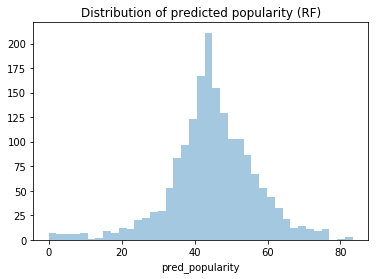

In [44]:
# Plot popularity distribution
sns.distplot(dev_data["pred_popularity"], rug=False, kde=False).set_title("Distribution of predicted popularity (RF)")

## Gradient Boosting Regressor

In [26]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [27]:
test_preds = gbr.predict(x_dev)
print("Gradient Boosting Regressor Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Gradient Boosting Regressor Variance Score: {}".format(r2_score(test_preds, y_dev)))

Gradient Boosting Regressor Mean Squared Error: 165.44375667054175
Gradient Boosting Regressor Variance Score: -1.023501630125069


In [115]:
## XG Boosting Regressor (Hyperparamterized Gradient Boosting)

In [29]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from matplotlib.pylab import rcParams
import itertools

In [30]:
XGB = XGBRegressor(
    learning_rate=0.1,
    n_estimators=400,
    max_depth=4,
    min_child_weight=1,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=1)

XGB.fit(x_train, y_train)
test_preds = XGB.predict(x_dev)
accuracy = XGB.score(x_dev, y_dev)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("MSE: %.2f"
      % mean_squared_error(test_preds, y_dev))

Accuracy: 52.21%
MSE: 135.42


In [48]:
lr = [0.1, 0.3]
n_estimators = [300, 400]
max_depth = [3, 4]

gridsearch = []

for prod in itertools.product(lr, n_estimators, max_depth):
    gridsearch.append(prod)
gridsearch

[(0.1, 300, 3),
 (0.1, 300, 4),
 (0.1, 400, 3),
 (0.1, 400, 4),
 (0.3, 300, 3),
 (0.3, 300, 4),
 (0.3, 400, 3),
 (0.3, 400, 4)]

In [47]:
for hparams in gridsearch:
    lr, n_est, max_d = hparams
    print("Lr, num est, max depth: ", lr, n_est, max_d)
    XGB = XGBRegressor(
        learning_rate=lr,
        n_estimators=n_est,
        max_depth=max_d,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1)

    XGB.fit(x_train, y_train)
    test_preds = XGB.predict(x_dev)
    accuracy = XGB.score(x_dev, y_dev)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("MSE: %.2f"
          % mean_squared_error(test_preds, y_dev))

Lr, num est, max depth:  0.1 300 3
Accuracy: 44.93%
MSE: 146.50
Lr, num est, max depth:  0.1 300 4
Accuracy: 47.76%
MSE: 138.96
Lr, num est, max depth:  0.1 400 3
Accuracy: 45.72%
MSE: 144.39
Lr, num est, max depth:  0.1 400 4
Accuracy: 48.26%
MSE: 137.65
Lr, num est, max depth:  0.3 300 3
Accuracy: 46.92%
MSE: 141.20
Lr, num est, max depth:  0.3 300 4
Accuracy: 45.49%
MSE: 145.00
Lr, num est, max depth:  0.3 400 3
Accuracy: 47.51%
MSE: 139.62
Lr, num est, max depth:  0.3 400 4
Accuracy: 44.95%
MSE: 146.43
Lr, num est, max depth:  0.5 300 3
Accuracy: 41.40%
MSE: 155.89
Lr, num est, max depth:  0.5 300 4
Accuracy: 37.62%
MSE: 165.95
Lr, num est, max depth:  0.5 400 3
Accuracy: 40.49%
MSE: 158.30
Lr, num est, max depth:  0.5 400 4
Accuracy: 36.59%
MSE: 168.68


ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

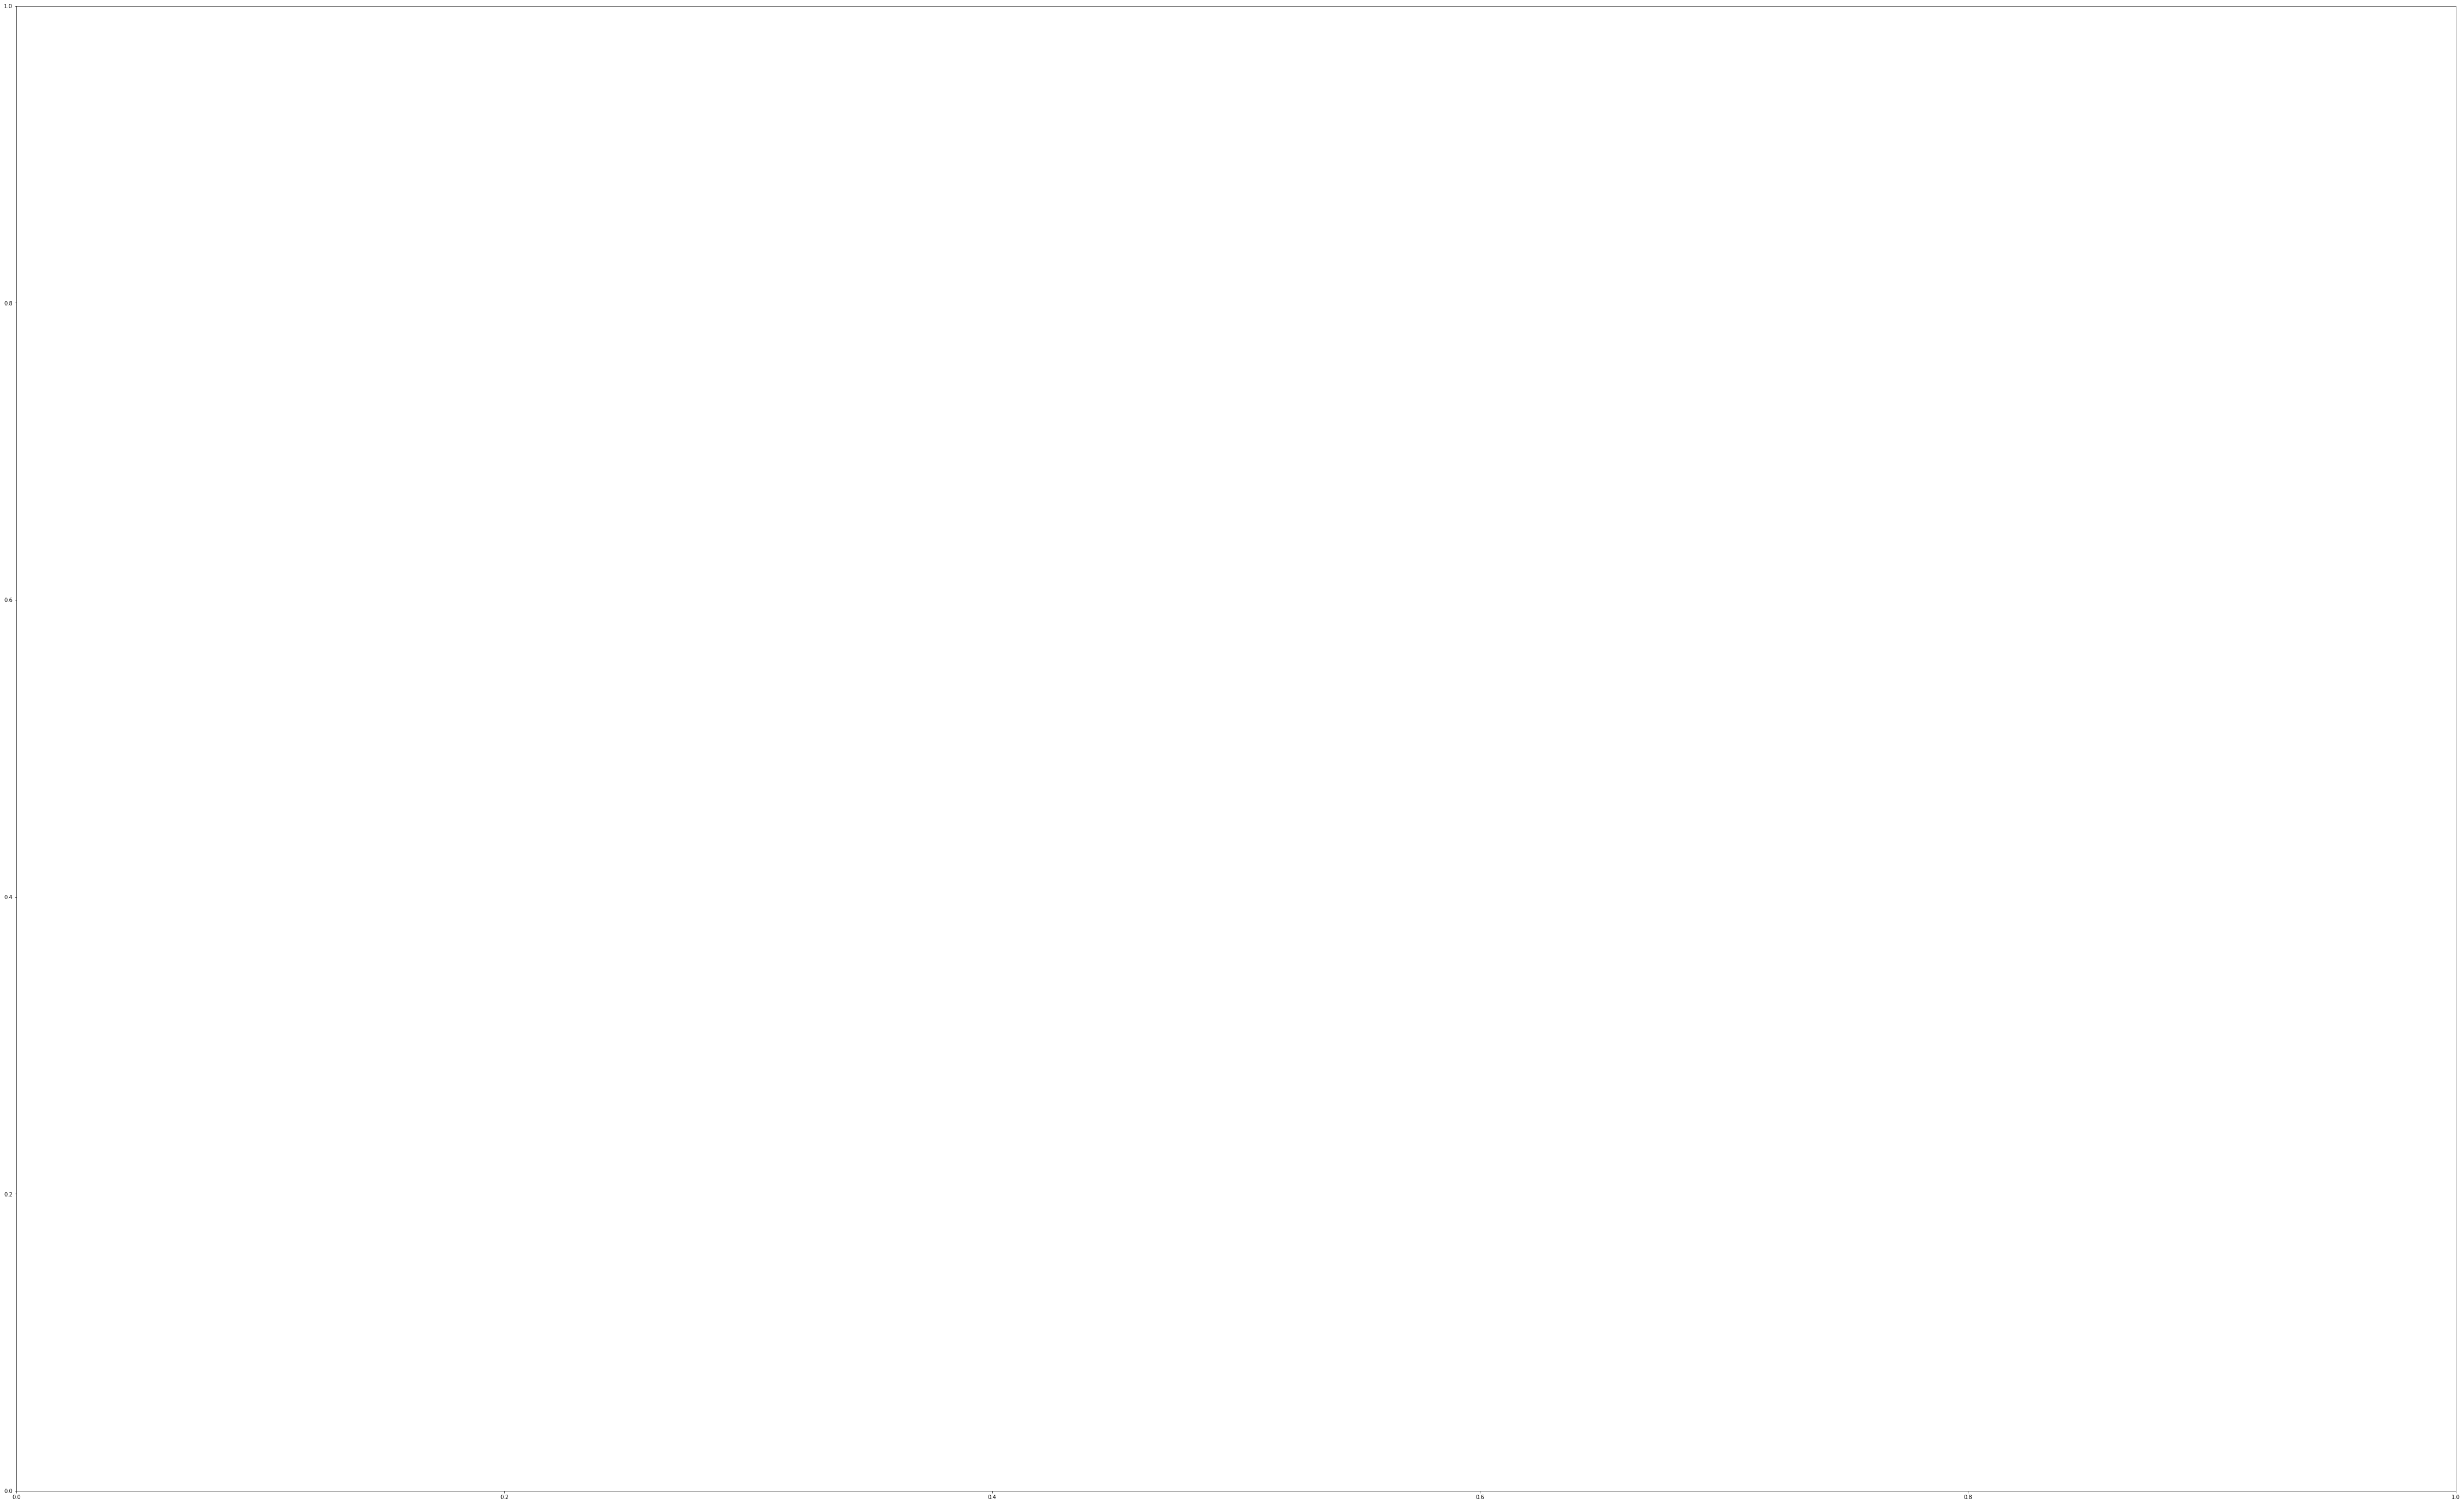

In [34]:
# Comment out to save memory

rcParams['figure.figsize'] = 80,50
plot_tree(XGB)
fig = plt.gcf()
fig.set_size_inches(50, 30)
fig.savefig('tree.eps')

In [ ]:
feat_imp = pd.Series(XGB.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar')
plt.xticks(size = 50)
plt.yticks(size = 60)
plt.suptitle('Feature Importances', fontsize=60)
plt.ylabel('Feature Importance Score', size = 60)
plt.savefig("FE.eps")